<a href="https://colab.research.google.com/github/BenedettaFrancesconi/Granger_DeepAR_Indonesia/blob/main/DeepAR_Knockoffs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# required packages

In [ ]:
!pip install git+https://github.com/josipd/torch-two-sample.git

  Cloning https://github.com/josipd/torch-two-sample.git to /tmp/pip-req-build-6v15w6eu
  Running command git clone --filter=blob:none --quiet https://github.com/josipd/torch-two-sample.git /tmp/pip-req-build-6v15w6eu
  Resolved https://github.com/josipd/torch-two-sample.git to commit 23aa002b1999a853de1b798832255af65114e9d8
  Preparing metadata (setup.py) ... done
  Created wheel for torch-two-sample: filename=torch_two_sample-0.1-cp310-cp310-linux_x86_64.whl size=139501 sha256=da9b530ba7dd0c267211ed9132d982f41dd7a63893ea3c4cca8043d0252e7512
  Stored in directory: /tmp/pip-ephem-wheel-cache-grftpa96/wheels/ba/6e/4d/c1545a8a3e392478d995c31ecb803ae54f0d2b9818003f6be5
Successfully built torch-two-sample


# mmd

In [ ]:
#!/usr/bin/env python
# encoding: utf-8

# code downloaded from https://github.com/OctoberChang/MMD-GAN/blob/master/mmd.py

import torch
import torch.nn.functional as F

min_var_est = 1e-8

# Consider linear time MMD with a linear kernel:
# K(f(x), f(y)) = f(x)^Tf(y)
# h(z_i, z_j) = k(x_i, x_j) + k(y_i, y_j) - k(x_i, y_j) - k(x_j, y_i)
#             = [f(x_i) - f(y_i)]^T[f(x_j) - f(y_j)]
#
# f_of_X: batch_size * k
# f_of_Y: batch_size * k
def linear_mmd2(f_of_X, f_of_Y):
    loss = 0.0
    delta = f_of_X - f_of_Y
    loss = torch.mean((delta[:-1] * delta[1:]).sum(1))
    return loss


# Consider linear time MMD with a polynomial kernel:
# K(f(x), f(y)) = (alpha*f(x)^Tf(y) + c)^d
# f_of_X: batch_size * k
# f_of_Y: batch_size * k
def poly_mmd2(f_of_X, f_of_Y, d=2, alpha=1.0, c=2.0):
    K_XX = (alpha * (f_of_X[:-1] * f_of_X[1:]).sum(1) + c)
    K_XX_mean = torch.mean(K_XX.pow(d))

    K_YY = (alpha * (f_of_Y[:-1] * f_of_Y[1:]).sum(1) + c)
    K_YY_mean = torch.mean(K_YY.pow(d))

    K_XY = (alpha * (f_of_X[:-1] * f_of_Y[1:]).sum(1) + c)
    K_XY_mean = torch.mean(K_XY.pow(d))

    K_YX = (alpha * (f_of_Y[:-1] * f_of_X[1:]).sum(1) + c)
    K_YX_mean = torch.mean(K_YX.pow(d))

    return K_XX_mean + K_YY_mean - K_XY_mean - K_YX_mean


def _mix_rbf_kernel(X, Y, sigma_list):
    assert(X.size(0) == Y.size(0))
    m = X.size(0)

    Z = torch.cat((X, Y), 0)
    ZZT = torch.mm(Z, Z.t())
    diag_ZZT = torch.diag(ZZT).unsqueeze(1)
    Z_norm_sqr = diag_ZZT.expand_as(ZZT)
    exponent = Z_norm_sqr - 2 * ZZT + Z_norm_sqr.t()

    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma**2)
        K += torch.exp(-gamma * exponent)

    return K[:m, :m], K[:m, m:], K[m:, m:], len(sigma_list)

def _mix_imq_kernel(X,
               Y,
               sigma_list):

    assert(X.size(0) == Y.size(0))
    m = X.size(0)
    h_dim = X.size(1)

    Z = torch.cat((X, Y), 0)
    ZZT = torch.mm(Z, Z.t())
    diag_ZZT = torch.diag(ZZT).unsqueeze(1)
    Z_norm_sqr = diag_ZZT.expand_as(ZZT)

    exponent = Z_norm_sqr - 2 * ZZT + Z_norm_sqr.t()

    K = 0.0
    for sigma in sigma_list:
        gamma = 2 * h_dim * 1.0 * sigma**2
        K += gamma / (gamma + exponent)

    return K[:m, :m], K[:m, m:], K[m:, m:], len(sigma_list)

def mix_imq_mmd2(X, Y, sigma_list, biased=True):
    K_XX, K_XY, K_YY, d = _mix_imq_kernel(X, Y, sigma_list)
    # return _mmd2(K_XX, K_XY, K_YY, const_diagonal=d, biased=biased)
    return _mmd2(K_XX, K_XY, K_YY, const_diagonal=False, biased=biased)

def mix_rbf_mmd2(X, Y, sigma_list, biased=True):
    K_XX, K_XY, K_YY, d = _mix_rbf_kernel(X, Y, sigma_list)
    # return _mmd2(K_XX, K_XY, K_YY, const_diagonal=d, biased=biased)
    return _mmd2(K_XX, K_XY, K_YY, const_diagonal=False, biased=biased)

def mix_rbf_mmd2_loss(X, Y, sigma_list, biased=True):

    mmd_dist_ref = mix_rbf_mmd2(X, Y, sigma_list, biased=True)
    return torch.sqrt(F.relu(mmd_dist_ref))

def mix_rbf_mmd2_unbiased_loss(X, Y, sigma_list):

    K_XX, K_XY, K_YY, d = _mix_rbf_kernel(X, Y, sigma_list)
    mmd_dist_ref = _mmd2_ignore_diagonals(K_XX, K_XY, K_YY, const_diagonal=False, biased=False)
    return torch.sqrt(F.relu(torch.abs(mmd_dist_ref)))

def mix_rbf_mmd2_and_ratio(X, Y, sigma_list, biased=True):
    K_XX, K_XY, K_YY, d = _mix_rbf_kernel(X, Y, sigma_list)
    # return _mmd2_and_ratio(K_XX, K_XY, K_YY, const_diagonal=d, biased=biased)
    return _mmd2_and_ratio(K_XX, K_XY, K_YY, const_diagonal=False, biased=biased)


################################################################################
# Helper functions to compute variances based on kernel matrices
################################################################################


def _mmd2_ignore_diagonals(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    m = K_XX.size(0)    # assume X, Y are same shape

    # Get the various sums of kernels that we'll use
    # Kts drop the diagonal, but we don't need to compute them explicitly
    if const_diagonal is not False:
        diag_X = diag_Y = diag_XY = const_diagonal
        sum_diag_X = sum_diag_Y = sum_diag_XY = m * const_diagonal
    else:
        diag_X = torch.diag(K_XX)            # (m,)
        diag_Y = torch.diag(K_YY)            # (m,)
        diag_XY = torch.diag(K_XY)           # (m,)
        sum_diag_X = torch.sum(diag_X)
        sum_diag_Y = torch.sum(diag_Y)
        sum_diag_XY = torch.sum(diag_XY)


    Kt_XX_sums = K_XX.sum(dim=1) - diag_X             # \tilde{K}_XX * e = K_XX * e - diag_X
    Kt_YY_sums = K_YY.sum(dim=1) - diag_Y             # \tilde{K}_YY * e = K_YY * e - diag_Y
    K_XY_sums_0 = K_XY.sum(dim=0) - diag_XY                     # K_{XY}^T * e

    Kt_XX_sum = Kt_XX_sums.sum()                       # e^T * \tilde{K}_XX * e
    Kt_YY_sum = Kt_YY_sums.sum()                       # e^T * \tilde{K}_YY * e
    K_XY_sum = K_XY_sums_0.sum()                       # e^T * K_{XY} * e

    if biased:
        mmd2 = ((Kt_XX_sum + sum_diag_X) / (m * m)
            + (Kt_YY_sum + sum_diag_Y) / (m * m)
            - 2.0 * (K_XY_sum + sum_diag_XY) / (m * m))
    else:
        mmd2 = ((Kt_XX_sum ) / (m * (m-1))
            + (Kt_YY_sum) / (m * (m-1))
            - 2.0 * (K_XY_sum) / (m * (m-1)))

    return mmd2


def _mmd2(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    m = K_XX.size(0)    # assume X, Y are same shape

    # Get the various sums of kernels that we'll use
    # Kts drop the diagonal, but we don't need to compute them explicitly
    if const_diagonal is not False:
        diag_X = diag_Y = const_diagonal
        sum_diag_X = sum_diag_Y = m * const_diagonal
    else:
        diag_X = torch.diag(K_XX)                       # (m,)
        diag_Y = torch.diag(K_YY)                       # (m,)
        sum_diag_X = torch.sum(diag_X)
        sum_diag_Y = torch.sum(diag_Y)

    Kt_XX_sums = K_XX.sum(dim=1) - diag_X             # \tilde{K}_XX * e = K_XX * e - diag_X
    Kt_YY_sums = K_YY.sum(dim=1) - diag_Y             # \tilde{K}_YY * e = K_YY * e - diag_Y
    K_XY_sums_0 = K_XY.sum(dim=0)                     # K_{XY}^T * e

    Kt_XX_sum = Kt_XX_sums.sum()                       # e^T * \tilde{K}_XX * e
    Kt_YY_sum = Kt_YY_sums.sum()                       # e^T * \tilde{K}_YY * e
    K_XY_sum = K_XY_sums_0.sum()                       # e^T * K_{XY} * e

    if biased:
        mmd2 = ((Kt_XX_sum + sum_diag_X) / (m * m)
            + (Kt_YY_sum + sum_diag_Y) / (m * m)
            - 2.0 * K_XY_sum / (m * m))
    else:
        mmd2 = (Kt_XX_sum / (m * (m - 1))
            + Kt_YY_sum / (m * (m - 1))
            - 2.0 * K_XY_sum / (m * m))

    return mmd2


def _mmd2_and_ratio(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    mmd2, var_est = _mmd2_and_variance(K_XX, K_XY, K_YY, const_diagonal=const_diagonal, biased=biased)
    loss = mmd2 / torch.sqrt(torch.clamp(var_est, min=min_var_est))
    return loss, mmd2, var_est


def _mmd2_and_variance(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    m = K_XX.size(0)    # assume X, Y are same shape

    # Get the various sums of kernels that we'll use
    # Kts drop the diagonal, but we don't need to compute them explicitly
    if const_diagonal is not False:
        diag_X = diag_Y = const_diagonal
        sum_diag_X = sum_diag_Y = m * const_diagonal
        sum_diag2_X = sum_diag2_Y = m * const_diagonal**2
    else:
        diag_X = torch.diag(K_XX)                       # (m,)
        diag_Y = torch.diag(K_YY)                       # (m,)
        sum_diag_X = torch.sum(diag_X)
        sum_diag_Y = torch.sum(diag_Y)
        sum_diag2_X = diag_X.dot(diag_X)
        sum_diag2_Y = diag_Y.dot(diag_Y)

    Kt_XX_sums = K_XX.sum(dim=1) - diag_X             # \tilde{K}_XX * e = K_XX * e - diag_X
    Kt_YY_sums = K_YY.sum(dim=1) - diag_Y             # \tilde{K}_YY * e = K_YY * e - diag_Y
    K_XY_sums_0 = K_XY.sum(dim=0)                     # K_{XY}^T * e
    K_XY_sums_1 = K_XY.sum(dim=1)                     # K_{XY} * e

    Kt_XX_sum = Kt_XX_sums.sum()                       # e^T * \tilde{K}_XX * e
    Kt_YY_sum = Kt_YY_sums.sum()                       # e^T * \tilde{K}_YY * e
    K_XY_sum = K_XY_sums_0.sum()                       # e^T * K_{XY} * e

    Kt_XX_2_sum = (K_XX ** 2).sum() - sum_diag2_X      # \| \tilde{K}_XX \|_F^2
    Kt_YY_2_sum = (K_YY ** 2).sum() - sum_diag2_Y      # \| \tilde{K}_YY \|_F^2
    K_XY_2_sum  = (K_XY ** 2).sum()                    # \| K_{XY} \|_F^2

    if biased:
        mmd2 = ((Kt_XX_sum + sum_diag_X) / (m * m)
            + (Kt_YY_sum + sum_diag_Y) / (m * m)
            - 2.0 * K_XY_sum / (m * m))
    else:
        mmd2 = (Kt_XX_sum / (m * (m - 1))
            + Kt_YY_sum / (m * (m - 1))
            - 2.0 * K_XY_sum / (m * m))

    var_est = (
        2.0 / (m**2 * (m - 1.0)**2) * (2 * Kt_XX_sums.dot(Kt_XX_sums) - Kt_XX_2_sum + 2 * Kt_YY_sums.dot(Kt_YY_sums) - Kt_YY_2_sum)
        - (4.0*m - 6.0) / (m**3 * (m - 1.0)**3) * (Kt_XX_sum**2 + Kt_YY_sum**2)
        + 4.0*(m - 2.0) / (m**3 * (m - 1.0)**2) * (K_XY_sums_1.dot(K_XY_sums_1) + K_XY_sums_0.dot(K_XY_sums_0))
        - 4.0*(m - 3.0) / (m**3 * (m - 1.0)**2) * (K_XY_2_sum) - (8 * m - 12) / (m**5 * (m - 1)) * K_XY_sum**2
        + 8.0 / (m**3 * (m - 1.0)) * (
            1.0 / m * (Kt_XX_sum + Kt_YY_sum) * K_XY_sum
            - Kt_XX_sums.dot(K_XY_sums_1)
            - Kt_YY_sums.dot(K_XY_sums_0))
        )
    return mmd2, var_est

# machine

In [ ]:
import os
import sys
import math
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
#from DeepKnockoffs.mmd import mix_rbf_mmd2_loss
np.warnings.filterwarnings('ignore')

def covariance_diff_biased(X, Xk, SigmaHat, Mask, scale=1.0):
    """ Second-order loss function, as described in deep knockoffs manuscript
    :param X: input data
    :param Xk: generated knockoffs
    :param SigmaHat: target covariance matrix
    :param Mask: masking the diagonal of Cov(X,Xk)
    :param scale: scaling the loss function
    :return: second-order loss function
    """

    # Center X,Xk
    mX  = X  - torch.mean(X,0,keepdim=True)
    mXk = Xk - torch.mean(Xk,0,keepdim=True)
    # Compute covariance matrices
    SXkXk = torch.mm(torch.t(mXk),mXk)/mXk.shape[0]
    SXXk  = torch.mm(torch.t(mX),mXk)/mXk.shape[0]

    # Compute loss
    T  = (SigmaHat-SXkXk).pow(2).sum() / scale
    T += (Mask*(SigmaHat-SXXk)).pow(2).sum() / scale
    return T

def create_checkpoint_name(pars):
    """ Defines the filename of the network
    :param pars: training hyper-parameters
    :return: filename composed of the hyper-parameters
    """

    checkpoint_name = 'net'
    for key, value in pars.items():
        checkpoint_name += '_' + key
        if key == 'alphas':
            for i in range(len(pars['alphas'])):
                checkpoint_name += '_' + str(pars['alphas'][i])
        else:
            checkpoint_name += '_' + str(value)
    return checkpoint_name

def save_checkpoint(state, filename):
    """ Saves the most updatated network to filename and store the previous
    machine in filename + _prev.pth.tar' file
    :param state: training state of the machine
    :filename: filename to save the current machine
    """

    # keep the previous model
    if os.path.isfile(filename):
        os.rename(filename, filename + '_prev.pth.tar')
    # save new model
    torch.save(state, filename)

def gen_batches(n_samples, batch_size, n_reps):
    """ Divide input data into batches.
    :param data: input data
    :param batch_size: size of each batch
    :return: data divided into batches
    """
    batches = []
    for rep_id in range(n_reps):
        idx = np.random.permutation(n_samples)
        for i in range(0, math.floor(n_samples/batch_size)*batch_size, batch_size):
            window = np.arange(i,i+batch_size)
            new_batch = idx[window]
            batches += [new_batch]
    return(batches)

class Net(nn.Module):
    """ Deep knockoff network
    """
    def __init__(self, p, dim_h, family="continuous"):
        """ Constructor
        :param p: dimensions of data
        :param dim_h: width of the network (~6 layers are fixed)
        :param family: data type, either "continuous" or "binary"
        """
        super(Net, self).__init__()

        self.p = p
        self.dim_h = dim_h
        if (family=="continuous"):
            self.main = nn.Sequential(
                nn.Linear(2*self.p, self.dim_h, bias=False),
                nn.BatchNorm1d(self.dim_h),
                nn.PReLU(),
                nn.Linear(self.dim_h, self.dim_h, bias=False),
                nn.BatchNorm1d(self.dim_h),
                nn.PReLU(),
                nn.Linear(self.dim_h, self.dim_h, bias=False),
                nn.BatchNorm1d(self.dim_h),
                nn.PReLU(),
                nn.Linear(self.dim_h, self.dim_h, bias=False),
                nn.BatchNorm1d(self.dim_h),
                nn.PReLU(),
                nn.Linear(self.dim_h, self.dim_h, bias=False),
                nn.BatchNorm1d(self.dim_h),
                nn.PReLU(),
                nn.Linear(self.dim_h, self.dim_h, bias=False),
                nn.BatchNorm1d(self.dim_h),
                nn.PReLU(),
                nn.Linear(self.dim_h, self.p),
            )
        elif (family=="binary"):
            self.main = nn.Sequential(
                nn.Linear(2*self.p, self.dim_h, bias=False),
                nn.BatchNorm1d(self.dim_h, eps=1e-02),
                nn.PReLU(),
                nn.Linear(self.dim_h, self.dim_h, bias=False),
                nn.BatchNorm1d(self.dim_h, eps=1e-02),
                nn.PReLU(),
                nn.Linear(self.dim_h, self.dim_h, bias=False),
                nn.BatchNorm1d(self.dim_h, eps=1e-02),
                nn.PReLU(),
                nn.Linear(self.dim_h, self.dim_h, bias=False),
                nn.BatchNorm1d(self.dim_h, eps=1e-02),
                nn.PReLU(),
                nn.Linear(self.dim_h, self.dim_h, bias=False),
                nn.BatchNorm1d(self.dim_h, eps=1e-02),
                nn.PReLU(),
                nn.Linear(self.dim_h, self.dim_h, bias=False),
                nn.BatchNorm1d(self.dim_h, eps=1e-02),
                nn.PReLU(),
                nn.Linear(self.dim_h, self.p),
                nn.Sigmoid(),
                nn.BatchNorm1d(self.p, eps=1e-02),
            )
        else:
            sys.exit("Error: unknown family");

    def forward(self, x, noise):
        """ Sample knockoff copies of the data
        :param x: input data
        :param noise: random noise seed
        :returns the constructed knockoffs
        """
        x_cat = torch.cat((x,noise),1)
        x_cat[:,0::2] = x
        x_cat[:,1::2] = noise
        return self.main(x_cat)

def norm(X, p=2):
    if(p==np.inf):
        return(torch.max(torch.abs(X)))
    else:
        return(torch.norm(X,p))

class KnockoffMachine:
    """ Deep Knockoff machine
    """
    def __init__(self, pars, checkpoint_name=None, logs_name=None):
        """ Constructor
        :param pars: dictionary containing the following keys
                'family': data type, either "continuous" or "binary"
                'p': dimensions of data
                'epochs': number of training epochs
                'epoch_length': number of iterations over the full data per epoch
                'batch_size': batch size
                'test_size': size of test set
                'lr': learning rate for main training loop
                'lr_milestones': when to decrease learning rate, unused when equals to number of epochs
                'dim_h': width of the network
                'target_corr': target correlation between variables and knockoffs
                'LAMBDA': penalty encouraging second-order knockoffs
                'DELTA': decorrelation penalty hyper-parameter
                'GAMMA': penalty for MMD distance
                'alphas': kernel widths for the MMD measure (uniform weights)
        :param checkpoint_name: location to save the machine
        :param logs_name: location to save the logfile
        """
        # architecture parameters
        self.p = pars['p']
        self.dim_h = pars['dim_h']
        self.family = pars['family']

        # optimization parameters
        self.epochs = pars['epochs']
        self.epoch_length = pars['epoch_length']
        self.batch_size = pars['batch_size']
        self.test_size = pars['test_size']
        self.lr = pars['lr']
        self.lr_milestones = pars['lr_milestones']

        # loss function parameters
        self.alphas = pars['alphas']
        self.target_corr = torch.from_numpy(pars['target_corr']).float()
        self.DELTA = pars['DELTA']
        self.GAMMA = pars['GAMMA']
        self.LAMBDA = pars['LAMBDA']

        # noise seed
        self.noise_std = 1.0
        self.dim_noise = self.p

        # higher-order discrepency function
        self.matching_loss = mix_rbf_mmd2_loss
        self.matching_param = self.alphas

        # Normalize learning rate to avoid numerical issues
        self.lr = self.lr / np.max([self.DELTA, self.GAMMA, self.GAMMA, self.LAMBDA, 1.0])

        self.pars = pars
        if checkpoint_name == None:
            self.checkpoint_name = None
            self.best_checkpoint_name = None
        else:
            self.checkpoint_name = checkpoint_name + "_checkpoint.pth.tar"
            self.best_checkpoint_name = checkpoint_name + "_best.pth.tar"

        if logs_name == None:
            self.logs_name = None
        else:
            self.logs_name = logs_name

        self.resume_epoch = 0

        # init the network
        self.net = Net(self.p, self.dim_h, family=self.family)

    def compute_diagnostics(self, X, Xk, noise, test=False):
        """ Evaluates the different components of the loss function
        :param X: input data
        :param Xk: knockoffs of X
        :param noise: allocated tensor that is used to sample the noise seed
        :param test: compute the components of the loss on train (False) or test (True)
        :return diagnostics: a dictionary containing the following keys:
                 'Mean' : distance between the means of X and Xk
                 'Corr-Diag': correlation between X and Xk
                 'Corr-Full: ||Cov(X,X) - Cov(Xk,Xk)||_F^2 / ||Cov(X,X)||_F^2
                 'Corr-Swap: ||M(Cov(X,X) - Cov(Xk,Xk))||_F^2 / ||Cov(X,X)||_F^2
                             where M is a mask that excludes the diagonal
                 'Loss': the value of the loss function
                 'MMD-Full': discrepancy between (X',Xk') and (Xk'',X'')
                 'MMD-Swap': discrepancy between (X',Xk') and (X'',Xk'')_swap(s)
        """
        # Initialize dictionary of diagnostics
        diagnostics = dict()
        if test:
            diagnostics["Data"] = "test"
        else:
            diagnostics["Data"] = "train"

        ##############################
        # Second-order moments
        ##############################

        # Difference in means
        D_mean = X.mean(0) - Xk.mean(0)
        D_mean = (D_mean*D_mean).mean()
        diagnostics["Mean"] = D_mean.data.cpu().item()

        # Center and scale X, Xk
        mX = X - torch.mean(X,0,keepdim=True)
        mXk = Xk - torch.mean(Xk,0,keepdim=True)
        scaleX  = (mX*mX).mean(0,keepdim=True)
        scaleXk = (mXk*mXk).mean(0,keepdim=True)

        # Correlation between X and Xk
        scaleX[scaleX==0] = 1.0   # Prevent division by 0
        scaleXk[scaleXk==0] = 1.0 # Prevent division by 0
        mXs  = mX  / torch.sqrt(scaleX)
        mXks = mXk / torch.sqrt(scaleXk)
        corr = (mXs*mXks).mean()
        diagnostics["Corr-Diag"] = corr.data.cpu().item()

        # Cov(Xk,Xk)
        Sigma = torch.mm(torch.t(mXs),mXs)/mXs.shape[0]
        Sigma_ko = torch.mm(torch.t(mXks),mXks)/mXk.shape[0]
        DK_2 = norm(Sigma_ko-Sigma) / norm(Sigma)
        diagnostics["Corr-Full"] = DK_2.data.cpu().item()

        # Cov(Xk,X) excluding the diagonal elements
        SigIntra_est = torch.mm(torch.t(mXks),mXs)/mXk.shape[0]
        DS_2 = norm(self.Mask*(SigIntra_est-Sigma)) / norm(Sigma)
        diagnostics["Corr-Swap"] = DS_2.data.cpu().item()

        ##############################
        # Loss function
        ##############################
        _, loss_display, mmd_full, mmd_swap = self.loss(X[:noise.shape[0]], Xk[:noise.shape[0]], test=True)
        diagnostics["Loss"]  = loss_display.data.cpu().item()
        diagnostics["MMD-Full"] = mmd_full.data.cpu().item()
        diagnostics["MMD-Swap"] = mmd_swap.data.cpu().item()

        # Return dictionary of diagnostics
        return diagnostics

    def loss(self, X, Xk, test=False):
        """ Evaluates the loss function
        :param X: input data
        :param Xk: knockoffs of X
        :param test: evaluate the MMD, regardless the value of GAMMA
        :return loss: the value of the effective loss function
                loss_display: a copy of the loss variable that will be used for display
                mmd_full: discrepancy between (X',Xk') and (Xk'',X'')
                mmd_swap: discrepancy between (X',Xk') and (X'',Xk'')_swap(s)
        """

        # Divide the observations into two disjoint batches
        n = int(X.shape[0]/2)
        X1,Xk1 = X[:n], Xk[:n]
        X2,Xk2 = X[n:(2*n)], Xk[n:(2*n)]

        # Joint variables
        Z1 = torch.cat((X1,Xk1),1)
        Z2 = torch.cat((Xk2,X2),1)
        Z3 = torch.cat((X2,Xk2),1).clone()
        swap_inds = np.where(np.random.binomial(1,0.5,size=self.p))[0]
        Z3[:,swap_inds] = Xk2[:,swap_inds]
        Z3[:,swap_inds+self.p] = X2[:,swap_inds]

        # Compute the discrepancy between (X,Xk) and (Xk,X)
        mmd_full = 0.0
        # Compute the discrepancy between (X,Xk) and (X,Xk)_s
        mmd_swap = 0.0
        if(self.GAMMA>0 or test):
            # Evaluate the MMD by following section 4.3 in
            # Li et al. "Generative Moment Matching Networks". Link to
            # the manuscript -- https://arxiv.org/pdf/1502.02761.pdf
            mmd_full = self.matching_loss(Z1, Z2, self.matching_param)
            mmd_swap = self.matching_loss(Z1, Z3, self.matching_param)

        # Match first two moments
        loss_moments = 0.0
        if self.LAMBDA>0:
            # First moment
            D_mean = X.mean(0) - Xk.mean(0)
            loss_1m = D_mean.pow(2).sum()
            # Second moments
            loss_2m = covariance_diff_biased(X, Xk, self.SigmaHat, self.Mask, scale=self.Sigma_norm)
            # Combine moments
            loss_moments = loss_1m + loss_2m

        # Penalize correlations between variables and knockoffs
        loss_corr = 0.0
        if self.DELTA>0:
            # Center X and Xk
            mX  = X  - torch.mean(X,0,keepdim=True)
            mXk = Xk - torch.mean(Xk,0,keepdim=True)
            # Correlation between X and Xk
            eps = 1e-3
            scaleX  = mX.pow(2).mean(0,keepdim=True)
            scaleXk = mXk.pow(2).mean(0,keepdim=True)
            mXs  = mX / (eps+torch.sqrt(scaleX))
            mXks = mXk / (eps+torch.sqrt(scaleXk))
            corr_XXk = (mXs*mXks).mean(0)
            loss_corr = (corr_XXk-self.target_corr).pow(2).mean()

        # Combine the loss functions
        loss = self.GAMMA*mmd_full + self.GAMMA*mmd_swap + self.LAMBDA*loss_moments + self.DELTA*loss_corr
        loss_display = loss
        return loss, loss_display, mmd_full, mmd_swap


    def train(self, X_in, resume = False):
        """ Fit the machine to the training data
        :param X_in: input data
        :param resume: proceed the training by loading the last checkpoint
        """

        # Divide data into training/test set
        X = torch.from_numpy(X_in[self.test_size:]).float()
        if(self.test_size>0):
            X_test = torch.from_numpy(X_in[:self.test_size]).float()
        else:
            X_test = torch.zeros(0, self.p)

        # used to compute statistics and diagnostics
        self.SigmaHat = np.cov(X,rowvar=False)
        self.SigmaHat = torch.from_numpy(self.SigmaHat).float()
        self.Mask = torch.ones(self.p, self.p) - torch.eye(self.p)

        # allocate a matrix for the noise realization
        noise = torch.zeros(self.batch_size,self.dim_noise)
        noise_test = torch.zeros(X_test.shape[0],self.dim_noise)
        use_cuda = torch.cuda.is_available()

        if resume == True:  # load the last checkpoint
            self.load(self.checkpoint_name)
            self.net.train()
        else:  # start learning from scratch
            self.net.train()
            # Define the optimization method
            self.net_optim = optim.SGD(self.net.parameters(), lr = self.lr, momentum=0.9)
            # Define the scheduler
            self.net_sched = optim.lr_scheduler.MultiStepLR(self.net_optim, gamma=0.1,
                                                            milestones=self.lr_milestones)

        # bandwidth parameters of the Gaussian kernel
        self.matching_param = self.alphas

        # move data to GPU if available
        if use_cuda:
            self.SigmaHat = self.SigmaHat.cuda()
            self.Mask = self.Mask.cuda()
            self.net = self.net.cuda()
            X = X.cuda()
            X_test = X_test.cuda()
            noise = noise.cuda()
            noise_test = noise_test.cuda()
            self.target_corr = self.target_corr.cuda()

        Xk = 0*X
        self.Sigma_norm = self.SigmaHat.pow(2).sum()
        self.Sigma_norm_cross = (self.Mask*self.SigmaHat).pow(2).sum()

        # Store diagnostics
        diagnostics = pd.DataFrame()
        losses_test = []

        # main training loop
        for epoch in range(self.resume_epoch, self.epochs):
            # prepare for training phase
            self.net.train()
            # update the learning rate scheduler
            self.net_sched.step()
            # divide the data into batches
            batches = gen_batches(X.size(0), self.batch_size, self.epoch_length)

            losses = []
            losses_dist_swap = []
            losses_dist_full = []

            for batch in batches:
                # Extract data for this batch
                X_batch  = X[batch,:]

                self.net_optim.zero_grad()

                # Run the network
                Xk_batch = self.net(X_batch, self.noise_std*noise.normal_())

                # Compute the loss function
                loss, loss_display, mmd_full, mmd_swap = self.loss(X_batch, Xk_batch)

                # Compute the gradient
                loss.backward()

                # Take a gradient step
                self.net_optim.step()

                # Save history
                losses.append(loss_display.data.cpu().item())
                if self.GAMMA>0:
                    losses_dist_swap.append(mmd_swap.data.cpu().item())
                    losses_dist_full.append(mmd_full.data.cpu().item())

                # Save the knockoffs
                Xk[batch, :] = Xk_batch.data

            ##############################
            # Compute diagnostics
            ##############################

            # Prepare for testing phase
            self.net.eval()

            # Evaluate the diagnostics on the training data, the following
            # function recomputes the loss on the training data
            diagnostics_train = self.compute_diagnostics(X, Xk, noise, test=False)
            diagnostics_train["Loss"] = np.mean(losses)
            if(self.GAMMA>0 and self.GAMMA>0):
                diagnostics_train["MMD-Full"] = np.mean(losses_dist_full)
                diagnostics_train["MMD-Swap"] = np.mean(losses_dist_swap)
            diagnostics_train["Epoch"] = epoch
            diagnostics = diagnostics.append(diagnostics_train, ignore_index=True)

            # Evaluate the diagnostics on the test data if available
            if(self.test_size>0):
                Xk_test = self.net(X_test, self.noise_std*noise_test.normal_())
                diagnostics_test = self.compute_diagnostics(X_test, Xk_test, noise_test, test=True)
            else:
                diagnostics_test = {key:np.nan for key in diagnostics_train.keys()}
            diagnostics_test["Epoch"] = epoch
            diagnostics = diagnostics.append(diagnostics_test, ignore_index=True)

            # If the test loss is at a minimum, save the machine to
            # the location pointed by best_checkpoint_name
            losses_test.append(diagnostics_test["Loss"])
            if((self.test_size>0) and (diagnostics_test["Loss"] == np.min(losses_test)) and \
               (self.best_checkpoint_name is not None)):
                best_machine = True
                save_checkpoint({
                    'epochs': epoch+1,
                    'pars'  : self.pars,
                    'state_dict': self.net.state_dict(),
                    'optimizer' : self.net_optim.state_dict(),
                    'scheduler' : self.net_sched.state_dict(),
                }, self.best_checkpoint_name)
            else:
                best_machine = False

            ##############################
            # Print progress
            ##############################
            if(self.test_size>0):
                print("[%4d/%4d], Loss: (%.4f, %.4f)" %
                      (epoch + 1, self.epochs, diagnostics_train["Loss"], diagnostics_test["Loss"]), end=", ")
                print("MMD: (%.4f,%.4f)" %
                      (diagnostics_train["MMD-Full"]+diagnostics_train["MMD-Swap"],
                       diagnostics_test["MMD-Full"]+diagnostics_test["MMD-Swap"]), end=", ")
                print("Cov: (%.3f,%.3f)" %
                      (diagnostics_train["Corr-Full"]+diagnostics_train["Corr-Swap"],
                       diagnostics_test["Corr-Full"]+diagnostics_test["Corr-Swap"]), end=", ")
                print("Decorr: (%.3f,%.3f)" %
                      (diagnostics_train["Corr-Diag"], diagnostics_test["Corr-Diag"]), end="")
                if best_machine:
                    print(" *", end="")
            else:
                print("[%4d/%4d], Loss: %.4f" %
                      (epoch + 1, self.epochs, diagnostics_train["Loss"]), end=", ")
                print("MMD: %.4f" %
                      (diagnostics_train["MMD-Full"] + diagnostics_train["MMD-Swap"]), end=", ")
                print("Cov: %.3f" %
                      (diagnostics_train["Corr-Full"] + diagnostics_train["Corr-Swap"]), end=", ")
                print("Decorr: %.3f" %
                      (diagnostics_train["Corr-Diag"]), end="")

            print("")
            sys.stdout.flush()

            # Save diagnostics to logfile
            if self.logs_name is not None:
                diagnostics.to_csv(self.logs_name, sep=" ", index=False)

            # Save the current machine to location checkpoint_name
            if self.checkpoint_name is not None:
                save_checkpoint({
                    'epochs': epoch+1,
                    'pars'  : self.pars,
                    'state_dict': self.net.state_dict(),
                    'optimizer' : self.net_optim.state_dict(),
                    'scheduler' : self.net_sched.state_dict(),
                }, self.checkpoint_name)

    def load(self, checkpoint_name):
        """ Load a machine from a stored checkpoint
        :param checkpoint_name: checkpoint name of a trained machine
        """
        filename = checkpoint_name + "_checkpoint.pth.tar"

        flag = 1
        if os.path.isfile(filename):
            print("=> loading checkpoint '{}'".format(filename))
            sys.stdout.flush()
            try:
                checkpoint = torch.load(filename, map_location='cpu')
            except:
                print("error loading saved model, trying the previous version")
                sys.stdout.flush()
                flag = 0

            if flag == 0:
                try:
                    checkpoint = torch.load(filename + '_prev.pth.tar', map_location='cpu')
                    flag = 1
                except:
                    print("error loading prev model, starting from scratch")
                    sys.stdout.flush()
                    flag = 0
        else:
            print("=> no checkpoint found at '{}'".format(filename))
            sys.stdout.flush()
            flag = 0

        if flag == 1:
                self.net.load_state_dict(checkpoint['state_dict'])
                if torch.cuda.is_available():
                    self.net = self.net.cuda()

                self.net_optim = optim.SGD(self.net.parameters(), lr = self.lr, momentum=0.9)
                self.net_optim.load_state_dict(checkpoint['optimizer'])
                self.net_sched = optim.lr_scheduler.MultiStepLR(self.net_optim, gamma=0.1,
                                                                milestones=self.lr_milestones)
                self.resume_epoch = checkpoint['epochs']

                print("=> loaded checkpoint '{}' (epoch {})"
                      .format(filename, checkpoint['epochs']))
                sys.stdout.flush()
        else:
            self.net.train()
            self.net_optim = optim.SGD(self.net.parameters(), lr = self.lr, momentum=0.9)
            self.net_sched = optim.lr_scheduler.MultiStepLR(self.net_optim, gamma=0.1,
                                                            milestones=self.lr_milestones)

            self.resume_epoch = 0

    def generate(self, X_in):
        """ Generate knockoff copies
        :param X_in: data samples
        :return Xk: knockoff copy per each sample in X
        """

        X = torch.from_numpy(X_in).float()
        self.net = self.net.cpu()
        self.net.eval()

        # Run the network in evaluation mode
        Xk = self.net(X, self.noise_std*torch.randn(X.size(0),self.dim_noise))
        Xk = Xk.data.cpu().numpy()

        return Xk

# filter

In [ ]:
import numpy as np

def kfilter(W, offset=1.0, q=0.1):
    """
    Adaptive significance threshold with the knockoff filter
    :param W: vector of knockoff statistics
    :param offset: equal to one for strict false discovery rate control
    :param q: nominal false discovery rate
    :return a threshold value for which the estimated FDP is less or equal q
    """
    t = np.insert(np.abs(W[W!=0]),0,0)
    t = np.sort(t)
    ratio = np.zeros(len(t));
    for i in range(len(t)):
        ratio[i] = (offset + np.sum(W <= -t[i])) / np.maximum(1.0, np.sum(W >= t[i]))

    index = np.where(ratio <= q)[0]
    if len(index)==0:
        thresh = float('inf')
    else:
        thresh = t[index[0]]

    return thresh

# Gaussian

In [ ]:
import numpy as np
import cvxpy as cvx
from scipy import linalg
import warnings

def cov2cor(Sigma):
    """
    Converts a covariance matrix to a correlation matrix
    :param Sigma : A covariance matrix (p x p)
    :return: A correlation matrix (p x p)
    """
    sqrtDiagSigma = np.sqrt(np.diag(Sigma))
    scalingFactors = np.outer(sqrtDiagSigma,sqrtDiagSigma)
    return np.divide(Sigma, scalingFactors)

def solve_sdp(Sigma, tol=1e-3):
    """
    Computes s for sdp-correlated Gaussian knockoffs
    :param Sigma : A covariance matrix (p x p)
    :param mu    : An array of means (p x 1)
    :return: A matrix of knockoff variables (n x p)
    """

    # Convert the covariance matrix to a correlation matrix
    # Check whether Sigma is positive definite
    if(np.min(np.linalg.eigvals(Sigma))<0):
        corrMatrix = cov2cor(Sigma + (1e-8)*np.eye(Sigma.shape[0]))
    else:
        corrMatrix = cov2cor(Sigma)

    p,_ = corrMatrix.shape
    s = cvx.Variable(p)
    objective = cvx.Maximize(sum(s))
    constraints = [ 2.0*corrMatrix >> cvx.diag(s) + cvx.diag([tol]*p), 0<=s, s<=1]
    prob = cvx.Problem(objective, constraints)
    prob.solve(solver='CVXOPT')

    assert prob.status == cvx.OPTIMAL

    s = np.clip(np.asarray(s.value).flatten(), 0, 1)

    # Scale back the results for a covariance matrix
    return np.multiply(s, np.diag(Sigma))

class GaussianKnockoffs:
    """
    Class GaussianKnockoffs
    Knockoffs for a multivariate Gaussian model
    """

    def __init__(self, Sigma, method="equi", mu=[], tol=1e-3):
        """
        Constructor
        :param model  : A multivariate Gaussian model object containing the covariance matrix
        :param method : Specifies how to determine the free parameters of Gaussian knockoffs.
                        Allowed values: "equi", "sdp" (default "equi")
        :return:
        """

        if len(mu)==0:
            self.mu = np.zeros((Sigma.shape[0],))
        else:
            self.mu = mu
        self.p = len(self.mu)
        self.Sigma = Sigma
        self.method = method

        # Initialize Gaussian knockoffs by computing either SDP or min(Eigs)

        if self.method=="equi":
            lambda_min = linalg.eigh(self.Sigma, eigvals_only=True, eigvals=(0,0))[0]
            s = min(1,2*(lambda_min-tol))
            self.Ds = np.diag([s]*self.Sigma.shape[0])
        elif self.method=="sdp":
            self.Ds = np.diag(solve_sdp(self.Sigma,tol=tol))
        else:
            raise ValueError('Invalid Gaussian knockoff type: '+self.method)
        self.SigmaInvDs = linalg.lstsq(self.Sigma,self.Ds)[0]
        self.V = 2.0*self.Ds - np.dot(self.Ds, self.SigmaInvDs)
        self.LV = np.linalg.cholesky(self.V+1e-10*np.eye(self.p))
        if linalg.eigh(self.V, eigvals_only=True, eigvals=(0,0))[0] <= tol:
            warnings.warn("Warning...........\
            The conditional covariance matrix for knockoffs is not positive definite. \
            Knockoffs will not have any power.")

    def generate(self, X):
        """
        Generate knockoffs for the multivariate Gaussian model
        :param X: A matrix of observations (n x p)
        :return: A matrix of knockoff variables (n x p)
        """
        n, p = X.shape
        muTilde = X - np.dot(X-np.tile(self.mu,(n,1)), self.SigmaInvDs)
        N = np.random.normal(size=muTilde.shape)
        return muTilde + np.dot(N,self.LV.T)

# data

In [ ]:
import numpy as np
import scipy.special as sp
from operator import mul
from functools import reduce

def covariance_AR1(p, rho):
    """
    Construct the covariance matrix of a Gaussian AR(1) process
    """
    assert len(rho)>0, "The list of coupling parameters must have non-zero length"
    assert 0 <= max(rho) <= 1, "The coupling parameters must be between 0 and 1"
    assert 0 <= min(rho) <= 1, "The coupling parameters must be between 0 and 1"

    # Construct the covariance matrix
    Sigma = np.zeros(shape=(p,p))
    for i in range(p):
        for j in range(i,p):
            Sigma[i][j] = reduce(mul, [rho[l] for l in range(i,j)], 1)
    Sigma = np.triu(Sigma)+np.triu(Sigma).T-np.diag(np.diag(Sigma))
    return Sigma

def cov2cor(Sigma):
    """
    Converts a covariance matrix to a correlation matrix
    :param Sigma : A covariance matrix (p x p)
    :return: A correlation matrix (p x p)
    """
    sqrtDiagSigma = np.sqrt(np.diag(Sigma))
    scalingFactors = np.outer(sqrtDiagSigma,sqrtDiagSigma)
    Sigma = np.divide(Sigma, scalingFactors)
    Sigma[np.diag_indices(Sigma.shape[0])] = 1
    return Sigma

def scramble(a, axis=1):
    """
    Return an array with the values of `a` independently shuffled along the
    given axis
    """
    b = np.random.random(a.shape)
    idx = np.argsort(b, axis=axis)
    shuffled = a[np.arange(a.shape[0])[:, None], idx]
    return shuffled

class GaussianAR1:
    """
    Gaussian AR(1) model
    """
    def __init__(self, p, rho):
        """
        Constructor
        :param p      : Number of variables
        :param rho    : A coupling parameter
        :return:
        """
        self.p = p
        self.rho = rho
        self.Sigma = covariance_AR1(self.p, [self.rho]*(self.p-1))
        self.mu = np.zeros((self.p,))

    def sample(self, n=1, **args):
        """
        Sample the observations from their marginal distribution
        :param n: The number of observations to be sampled (default 1)
        :return: numpy matrix (n x p)
        """
        return np.random.multivariate_normal(self.mu, self.Sigma, n)

class GaussianMixtureAR1:
    """
    Gaussian mixture of AR(1) model
    """

    def __init__(self, p, rho_list, proportions=None):
        # Dimensions
        self.p = p
        # Number of components
        self.K = len(rho_list)
        # Proportions for each Gaussian
        if(proportions==None):
            self.proportions = [1.0/self.K]*self.K
        else:
            self.proportions = proportions

        # Initialize Gaussian distributions
        self.normals = []
        self.Sigma = np.zeros((self.p,self.p))
        self.mu = np.zeros((self.p,))
        for k in range(self.K):
            rho = rho_list[k]
            self.normals.append(GaussianAR1(self.p, rho))
            self.Sigma += self.normals[k].Sigma / self.K

    def sample(self, n=1, **args):
        """
        Sample the observations from their marginal distribution
        :param n: The number of observations to be sampled (default 1)
        :return: numpy matrix (n x p)
        """
        # Sample vector of mixture IDs
        Z = np.random.choice(self.K, n, replace=True)
        # Sample multivariate Gaussians
        X = np.zeros((n,self.p))
        for k in range(self.K):
            k_idx = np.where(Z==k)[0]
            n_idx = len(k_idx)
            X[k_idx,:] = self.normals[k].sample(n_idx)
        return X

class SparseGaussian:
    """
    Uncorrelated but dependent variables
    """
    def __init__(self, p, m):
        self.p = p
        self.m = m
        # Compute true covariance matrix
        pAA = sp.binom(self.p-1, self.m-1) / sp.binom(self.p, self.m)
        pAB = sp.binom(self.p-2, self.m-2) / sp.binom(self.p, self.m)
        self.Sigma = np.eye(self.p)*pAA + (np.ones((self.p,self.p))-np.eye(self.p)) * pAB
        self.mu = np.zeros((self.p,))

    def sample(self, n=1, **args):
        L = np.repeat(np.reshape(range(self.p),(1,self.p)), n, axis=0)
        L = scramble(L)
        S = (L < self.m).astype("int")
        V = np.random.normal(0,1,(n,1))
        X = S * V
        return X

class MultivariateStudentT:
    """
    Multivariate Student's t distribution
    """
    def __init__(self, p, df, rho):
        assert df > 2, "Degrees of freedom must be > 2"
        self.p = p
        self.df = df
        self.rho = rho
        self.normal = GaussianAR1(p, rho)
        self.Sigma = self.normal.Sigma * self.df/(self.df-2.0)
        self.mu = np.zeros((self.p,))

    def sample(self, n=1, **args):
        '''
        Output:
        Produce M samples of d-dimensional multivariate t distribution
        Input:
        mu = mean (d dimensional numpy array or scalar)
        Sigma = scale matrix (dxd numpy array)
        df = degrees of freedom
        n = # of samples to produce
        '''
        Z = self.normal.sample(n)
        G = np.tile(np.random.gamma(self.df/2.,2./self.df,n),(self.p,1)).T
        return Z/np.sqrt(G)

class DataSampler:
    """
    Model for the explanatory variables
    """
    def __init__(self, params, standardize=True):
        self.p = params['p']
        self.standardize = standardize

        self.model_name = params["model"]
        if(self.model_name=="gaussian"):
            self.model = GaussianAR1(self.p, params["rho"])
            self.name = "gaussian"
        elif(self.model_name=="gmm"):
            self.model = GaussianMixtureAR1(self.p, params["rho-list"])
            self.name = "gmm"
        elif(self.model_name=="sparse"):
            self.model = SparseGaussian(self.p, params["sparsity"])
            self.name = "sparse"
        elif(self.model_name=="mstudent"):
            self.model = MultivariateStudentT(self.p, params["df"], params["rho"])
            self.name = "mstudent"
        else:
            raise Exception('Unknown model: '+self.model_name)

        # Center and scale distribution parameters
        if(self.standardize):
            self.Sigma = cov2cor(self.model.Sigma)
            self.mu = 0 * self.model.mu
        else:
            self.Sigma = self.model.Sigma
            self.mu = self.model.mu

    def scaler(self, X):
        return (X-self.model.mu) / np.sqrt(np.diag(self.model.Sigma))

    def sample(self, n, **args):
        X = self.model.sample(n, **args)
        if(self.standardize):
            X = self.scaler(X)
        return X

# diagnostic

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Function
#from DeepKnockoffs.mmd import mix_rbf_mmd2
import torch_two_sample.statistics_diff as diff_tests
import torch_two_sample.statistics_nondiff as nondiff_tests
import matplotlib.pyplot as plt
import sys

def PlotScatterHelper(A, B, ax=None):
    """
    Plot the entries of a matrix A vs those of B
    :param A: n-by-p data matrix
    :param B: n-by-p data matrix
    """
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = None

    ax.set_xlim([-0.2, 1.1])
    ax.set_ylim([-0.2, 1.1])

    for i in range(0,A.shape[0]-1):
        ax.scatter(A.diagonal(i),B.diagonal(i), alpha=0.2)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    for i in range(0,A.shape[0]-1):
        meanValA = np.mean(A.diagonal(i))
        meanValB = np.mean(B.diagonal(i))
        ax.plot([meanValA, meanValA],lims, 'k-', alpha=0.2, zorder=0)
        if i==0:
            color = 'r-'
            alpha = 1
        else:
            color = 'k-'
            alpha = 0.2
        ax.plot(lims, [meanValB, meanValB], color, alpha=alpha, zorder=0)

    # Plot both limits against each other
    ax.plot(lims, lims, 'k-', dashes=[2,2], alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    return ax

def ScatterCovariance(X, Xk):
    """ Plot the entries of Cov(Xk,Xk) vs Cov(X,X) and Cov(X,Xk) vs Cov(X,X)
    :param X: n-by-p matrix of original variables
    :param Xk: n-by-p matrix of knockoffs
    """
    # Create subplots
    fig, axarr = plt.subplots(1, 2, figsize=(14,7))

    # Originality
    XX = np.corrcoef(X.T)
    XkXk = np.corrcoef(Xk.T)
    PlotScatterHelper(XX, XkXk, ax=axarr[0])
    axarr[0].set_xlabel(r'$\hat{G}_{\mathbf{X}\mathbf{X}}(i,j)$')
    axarr[0].set_ylabel(r'$\hat{G}_{\tilde{\mathbf{X}}\tilde{\mathbf{X}}}(i,j)$')

    # Exchangeability
    p = X.shape[1]
    G = np.corrcoef(X.T, Xk.T)
    XX  = G[:p,:p]
    XXk = G[:p,p:(2*p)]
    PlotScatterHelper(XX, XXk, ax=axarr[1])
    axarr[1].set_xlabel(r'$\hat{G}_{\mathbf{X}\mathbf{X}}(i,j)$')
    axarr[1].set_ylabel(r'$\hat{G}_{\mathbf{X}\tilde{\mathbf{X}}}(i,j)$')

    return fig

def COV(Z1,Z2,alphas=None):
    """
    Unbiased estimate of the squared Frobenius
    norm difference between the covariance
    matrices of Z1 and Z2
    :param Z1: n-by-p matrix
    :param Z2: n-by-p matrix
    """
    assert(Z1.shape[1]==Z2.shape[1])
    n1 = Z1.shape[0]
    n2 = Z2.shape[0]
    # Center the data
    Z1 = Z1 - Z1.mean(0)
    Z2 = Z2 - Z2.mean(0)
    # Estimate the trace of Sigma1^2
    ZZ1 = torch.mm(Z1, Z1.t())
    A1 = (ZZ1-torch.diag(torch.diag(ZZ1))).pow(2).mean() * n1 / (n1-1)
    # Estimate the trace of Sigma2^2
    ZZ2 = torch.mm(Z2, Z2.t())
    A2 = (ZZ2-torch.diag(torch.diag(ZZ2))).pow(2).mean() * n2 / (n2-1)
    # Estimate  the trace of Sigma1 * Sigma2
    C = torch.mm(Z1,Z2.t()).pow(2).mean()
    # Compute statistic
    T = A1 + A2 - 2.0 * C
    return T.cpu().item()

def MMD(Z1, Z2, alphas):
    """
    Unbiased estimate of the maximum mean discrepancy
    between the distributions of Z1 and Z2
    :param Z1: n-by-p matrix
    :param Z2: n-by-p matrix
    :param alphas: vector of kernel widths
    """
    return mix_rbf_mmd2(Z1, Z2, alphas, biased=False).item()

def KNN(Z1, Z2, alphas, K=1):
    """
    K-nearest neighbor statistic for equality in distribution between Z1 and Z2
    :param Z1: n-by-p matrix
    :param Z2: n-by-p matrix
    """
    n = Z1.shape[0]
    test = nondiff_tests.KNNStatistic(n, n, k=K)
    test_value = test(Z1, Z2).item() / (K*2.0*n)
    return test_value

def Energy(Z1, Z2, alphas=None):
    """
    Energy statistic for equality in distribution between Z1 and Z2
    :param Z1: n-by-p matrix
    :param Z2: n-by-p matrix
    """
    n = Z1.shape[0]
    test = diff_tests.EnergyStatistic(n, n)
    return test(Z1, Z2, ret_matrix=False).item()

def compute_diagnostics(X, Xk, alphas, verbose=True):
    """
    Compute multiple knockoff diagnosics
    :param X: n-by-p matrix of original variables
    :param Xk: n-by-p matrix of knockoffs
    :param alphas: vector of kernel widths for the MMD estimate
    """
    # Divide data into batches
    n1 = int(X.shape[0]/2)
    X1,Xk1 = X[:n1], Xk[:n1]
    X2,Xk2 = X[n1:], Xk[n1:]

    tests = {'Covariance':COV, 'MMD':MMD, 'KNN':KNN, 'Energy':Energy}
    p = X1.shape[1]

    # Initialize results
    results = pd.DataFrame(columns=['Metric', 'Swap', 'Value'])

    # Compute self-correlations
    Ghat = np.corrcoef(X,Xk,rowvar=False)
    selfcorr = np.mean(np.abs(np.diag(Ghat[0:p,p:(2*p)])))
    if verbose:
        print("(Self-corr) : %.6f" %selfcorr)
    results = results.append({'Metric':'Covariance', 'Swap':'self', 'Value':selfcorr}, ignore_index=True)

    # Concatenate observations
    Z_ref = torch.cat((X1,Xk1),1)
    Z_ref2 = torch.cat((X2,Xk2),1)

    # Compute two-sample tests with full swap
    Z_fsw = torch.cat((Xk2,X2),1)
    for test_name,test in tests.items():
        value = test(Z_ref, Z_fsw, alphas)
        if verbose:
            print("%8s. %12s: %.6f" %(test_name, "Full swap", value))
        results = results.append({'Metric':test_name, 'Swap':'full', 'Value':value}, ignore_index=True)

    # Compute two-sample tests with partial swap
    for test_name,test in tests.items():
        swap_inds = np.where(np.random.binomial(1,0.5,size=p))[0]
        Z_psw = Z_ref2.clone()
        Z_psw[:,swap_inds]   = Xk2[:,swap_inds]
        Z_psw[:,swap_inds+p] = X2[:,swap_inds]
        value = test(Z_ref, Z_psw, alphas)

        if verbose:
            print("%8s. %12s: %.6f" %(test_name, "Partial swap", value))
        results = results.append({'Metric':test_name, 'Swap':'partial', 'Value':value}, ignore_index=True)

    return results

class KnockoffExam:
    def __init__(self, modelX, machines):
        """
        Initialize knockoff goodness-of-fit tests on independent data
        :param modelX: data generator
        :param machines: named list of knockoff generators
        """
        self.modelX = modelX
        self.machines = machines
        self.use_cuda = torch.cuda.is_available()

        # Parameters for diagnostics
        self.alphas = [1.,2.,4.,8.,16.,32.,64.,128.]

    def diagnose(self, n, n_exams, verbose=False):
        """
        Generate data and knockoffs, then compute goodness-of-fit diagnostics
        :param n: sample size for diagnostics
        :param n_exams: number of samples to compute diagnostics on
        :param verbose: whether to print show values of test statistics in real time
        """

        Results = pd.DataFrame(columns=['Method', 'Metric', 'Swap', 'Value', 'Sample'])
        print("Computing knockoff diagnostics...")
        for exam in range(n_exams):
            sys.stdout.write('\r')
            sys.stdout.write("[%-25s] %d%%" % ('='*int((exam+1)/n_exams*25), ((exam+1)/n_exams)*100))
            sys.stdout.flush()

            # Sample two batches of data simultaneously
            X_np = self.modelX.sample(2*n, test=True)

            for machine_name,machine in self.machines.items():
                if(machine is None):
                    continue

                # Sample knockoff copies
                if(machine == "joint-sampling"):
                    Xk = torch.from_numpy(Xk_oracle).float()
                elif(machine == "independent"):
                    Xk = torch.from_numpy(self.modelX.sample(X.shape[0])).float()
                else:
                    Xk = torch.from_numpy(machine.generate(X_np)).float()

                # Move data and knockoffs onto cuda, if available
                X = torch.from_numpy(X_np).float()
                if(self.use_cuda):
                    X = X.cuda()
                    Xk = Xk.cuda()

                # Compute diagnostics of knockoff quality
                new_res = compute_diagnostics(X, Xk, self.alphas, verbose=verbose)
                new_res["Method"] = machine_name
                new_res["Sample"] = exam

                # Save results
                Results = Results.append(new_res)

        return Results

In [ ]:
# !pip3 install torch torchvision

# parameters

In [ ]:
def GetDistributionParams(model,p):
    """
    Returns parameters for generating different data distributions
    """
    params = dict()
    params["model"] = model
    params["p"] = p
    if model == "gaussian":
        params["rho"] = 0.5
    elif model == "gmm":
        params["rho-list"] = [0.3,0.5,0.7]
    elif model == "mstudent":
        params["df"] = 3
        params["rho"] = 0.5
    elif model == "sparse":
        params["sparsity"] = int(0.3*p)
    else:
        raise Exception('Unknown model generating distribution: ' + model)

    return params

def GetTrainingHyperParams(model):
    """
    Returns the default hyperparameters for training deep knockoffs
    as described in the paper
    """
    params = dict()

    params['GAMMA'] = 1.0
    if model == "gaussian":
        params['LAMBDA'] = 1.0
        params['DELTA'] = 1.0
    elif model == "gmm":
        params['LAMBDA'] = 1.0
        params['DELTA'] = 1.0
    elif model == "mstudent":
        params['LAMBDA'] = 0.01
        params['DELTA'] = 0.01
    elif model == "sparse":
        params['LAMBDA'] = 0.1
        params['DELTA'] = 1.0
    else:
        raise Exception('Unknown data distribution: ' + model)

    return params

def GetFDRTestParams(model):
    """
    Returns the default hyperparameters for performing controlled
    variable selection experiments as described in the paper
    """
    params = dict()
    # Test parameters for each model
    if model in ["gaussian", "gmm"]:
        params["n"] = 150
        params["elasticnet_alpha"] = 0.1
    elif model in ["mstudent"]:
        params["n"] = 200
        params["elasticnet_alpha"] = 0.0
    elif model in ["sparse"]:
        params["n"] = 200
        params["elasticnet_alpha"] = 0.0

    return params

# toy example usage

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# from DeepKnockoffs import KnockoffMachine
# from DeepKnockoffs import GaussianKnockoffs
# import data
# import diagnostics
# import parameters

In [ ]:
p = 5

# Load the built-in Gaussian model and its default parameters
# The currently available built-in models are:
# - gaussian : Multivariate Gaussian distribution
# - gmm      : Gaussian mixture model
# - mstudent : Multivariate Student's-t distribution
# - sparse   : Multivariate sparse Gaussian distribution
model = "gaussian"
distribution_params = GetDistributionParams(model, p)

# Initialize the data generator
DataSampler = DataSampler(distribution_params)

In [ ]:
n = 400

# Sample training data
X_train = DataSampler.sample(n)
print("Generated a training dataset of size: %d x %d." %(X_train.shape))

Generated a training dataset of size: 400 x 5.


In [ ]:
# Compute the empirical covariance matrix of the training data
SigmaHat = np.cov(X_train, rowvar=False)

# Initialize generator of second-order knockoffs
second_order = GaussianKnockoffs(SigmaHat, mu=np.mean(X_train,0), method="sdp")

# Measure pairwise second-order knockoff correlations
corr_g = (np.diag(SigmaHat) - np.diag(second_order.Ds)) / np.diag(SigmaHat)

print('Average absolute pairwise correlation: %.3f.' %(np.mean(np.abs(corr_g))))
print(corr_g)

Average absolute pairwise correlation: 0.239.
[0.00000000e+00 3.75682942e-01 2.46867759e-01 5.72767533e-01
 2.79810317e-08]


In [ ]:
second_order.Ds

array([[1.00281296, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.62607966, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.70895402, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.45693487, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.97538776]])

In [ ]:
training_params = GetTrainingHyperParams(model)

# Set the parameters for training deep knockoffs
pars = dict()
# Number of epochs
pars['epochs'] = 10
# Number of iterations over the full data per epoch
pars['epoch_length'] = 50
# Data type, either "continuous" or "binary"
pars['family'] = "continuous"
# Dimensions of the data
pars['p'] = p
# Size of the test set
pars['test_size']  = int(0.1*n)
# Batch size
pars['batch_size'] = int(0.45*n)
# Learning rate
pars['lr'] = 0.01
# When to decrease learning rate (unused when equal to number of epochs)
pars['lr_milestones'] = [pars['epochs']]
# Width of the network (number of layers is fixed to 6)
pars['dim_h'] = int(10*p)
# Penalty for the MMD distance
pars['GAMMA'] = training_params['GAMMA']
# Penalty encouraging second-order knockoffs
pars['LAMBDA'] = training_params['LAMBDA']
# Decorrelation penalty hyperparameter
pars['DELTA'] = training_params['DELTA']
# Target pairwise correlations between variables and knockoffs
pars['target_corr'] = corr_g
# Kernel widths for the MMD measure (uniform weights)
pars['alphas'] = [1.,2.,4.,8.,16.,32.,64.,128.]

# Initialize the machine
machine = KnockoffMachine(pars)

In [ ]:
print("Fitting the knockoff machine...")
machine.train(X_train)

Fitting the knockoff machine...
[   1/  10], Loss: (0.6020, 1.3672), MMD: (0.4788,0.9388), Cov: (0.112,0.638), Decorr: (0.228,0.165)
[   2/  10], Loss: (0.4796, 1.1623), MMD: (0.4457,0.9767), Cov: (0.093,0.623), Decorr: (0.225,0.269)
[   3/  10], Loss: (0.4800, 1.0443), MMD: (0.4457,0.8595), Cov: (0.127,0.581), Decorr: (0.241,0.173)
[   4/  10], Loss: (0.4795, 1.3669), MMD: (0.4493,0.9715), Cov: (0.125,0.665), Decorr: (0.232,0.253)
[   5/  10], Loss: (0.4709, 1.3365), MMD: (0.4400,0.9993), Cov: (0.117,0.717), Decorr: (0.244,0.201)
[   6/  10], Loss: (0.4623, 1.1390), MMD: (0.4341,0.9726), Cov: (0.102,0.636), Decorr: (0.254,0.231)
[   7/  10], Loss: (0.4720, 1.1603), MMD: (0.4396,0.9662), Cov: (0.071,0.700), Decorr: (0.224,0.226)
[   8/  10], Loss: (0.4615, 1.0525), MMD: (0.4312,0.8344), Cov: (0.085,0.590), Decorr: (0.228,0.146)
[   9/  10], Loss: (0.4682, 1.1963), MMD: (0.4407,0.9274), Cov: (0.084,0.588), Decorr: (0.241,0.248)
[  10/  10], Loss: (0.4560, 1.0570), MMD: (0.4326,0.9100), 

In [ ]:
Xk_train_m = machine.generate(X_train)
print("Size of the deep knockoff dataset: %d x %d." %(Xk_train_m.shape))

# Generate second-order knockoffs
Xk_train_g = second_order.generate(X_train)
print("Size of the second-order knockoff dataset: %d x %d." %(Xk_train_g.shape))

Size of the deep knockoff dataset: 400 x 5.
Size of the second-order knockoff dataset: 400 x 5.


In [ ]:
Xk_train_m.shape

(400, 5)

In [ ]:
X_train.shape

(400, 5)

# My data

In [ ]:
## try with my data

import pandas as pd
df_crop = pd.read_csv('df_crop.csv')
df_rain = pd.read_csv('df_rain.csv')
df_sst = pd.read_csv('df_sst.csv')
df_tas = pd.read_csv('df_tas.csv')

df_crop['new_time'] = pd.to_datetime(df_rain['time'])
df_crop.index = df_crop['new_time']
df_crop = df_crop.drop(columns='time',axis=1)

df_tas['time'] = pd.to_datetime(df_tas['time'])
df_tas.index = df_tas['time']
df_tas = df_tas.drop(columns='time',axis=1)

df_rain['time'] = pd.to_datetime(df_rain['time'])
df_rain.index = df_rain['time']
df_rain = df_rain.drop(columns='time',axis=1)

df_sst['time'] = pd.to_datetime(df_sst['time'])
df_sst.index = df_sst['time']
df_sst = df_sst.drop(columns='time',axis=1)


#from gluonts.dataset.pandas import PandasDataset
df_final = pd.concat([df_tas, df_rain, df_sst['sst'], df_crop['cropFrac']], axis=1)
df_final.head()

,air,precip,sst,cropFrac
1979-07-01,-0.002713,5.431944,27.735752,2.936973
1979-08-01,0.127101,3.386111,27.539595,2.936973
1979-09-01,0.149556,5.865000,27.833902,2.936973
1979-10-01,0.156329,5.342500,28.360090,2.936973
1979-11-01,0.293725,8.013820,28.893454,2.936973


In [ ]:
df_crop.cropFrac.plot()

In [ ]:
df_final.describe()

In [ ]:
# df_final.index

In [ ]:
# Compute the empirical covariance matrix of the training data

SigmaHat = np.cov(df_final, rowvar=False)
SigmaHat

In [ ]:
np.mean(df_final,0)

air          0.407676
precip       6.598593
sst         28.702224
cropFrac     4.011410
dtype: float64

In [ ]:
df_log = np.log(df_final)
np.mean(df_log)

air        -1.111150
precip      1.832594
sst         3.356812
cropFrac    1.376263
dtype: float64

In [ ]:
# Initialize generator of second-order knockoffs

second_order = GaussianKnockoffs(SigmaHat, mu=np.mean(df_final,0), method="sdp")
second_order.Ds
#np.mean(df_final,0)

array([[0.02422849, 0.        , 0.        , 0.        ],
       [0.        , 4.35749224, 0.        , 0.        ],
       [0.        , 0.        , 0.12958292, 0.        ],
       [0.        , 0.        , 0.        , 0.41552496]])

In [ ]:
# Measure pairwise second-order knockoff correlations

corr_g = (np.diag(SigmaHat) - np.diag(second_order.Ds)) / np.diag(SigmaHat)

print('Average absolute pairwise correlation: %.3f.' %(np.mean(np.abs(corr_g))))
#print(corr_g)

Average absolute pairwise correlation: 0.292.


In [ ]:
df_final.shape[1]

4

In [ ]:
# Load the built-in Gaussian model and its default parameters
# The currently available built-in models are:
# - gaussian : Multivariate Gaussian distribution
# - gmm      : Gaussian mixture model
# - mstudent : Multivariate Student's-t distribution
# - sparse   : Multivariate sparse Gaussian distribution

model = "gaussian" ## only spares or gaussian work but why?

training_params = GetTrainingHyperParams(model)

p = df_final.shape[1]
n = df_final.shape[0]

# Set the parameters for training deep knockoffs
pars = dict()
# Number of epochs
pars['epochs'] = 10
# Number of iterations over the full data per epoch
pars['epoch_length'] = 9
# Data type, either "continuous" or "binary"
pars['family'] = "continuous"
# Dimensions of the data
pars['p'] = p
# Size of the test set
pars['test_size']  = int(0.1*n)
# Batch size
pars['batch_size'] = int(0.45*n)
# Learning rate
pars['lr'] = 0.01
# When to decrease learning rate (unused when equal to number of epochs)
pars['lr_milestones'] = [pars['epochs']]
# Width of the network (number of layers is fixed to 6)
pars['dim_h'] = int(10*p)
# Penalty for the MMD distance
pars['GAMMA'] = training_params['GAMMA']
# Penalty encouraging second-order knockoffs
pars['LAMBDA'] = training_params['LAMBDA']
# Decorrelation penalty hyperparameter
pars['DELTA'] = training_params['DELTA']
# Target pairwise correlations between variables and knockoffs
pars['target_corr'] = corr_g
# Kernel widths for the MMD measure (uniform weights)
#pars['alphas'] = [1.,2.,4.,8.,16.,32.,64.,128.]
pars['alphas'] = [1.]

# Initialize the machine
machine = KnockoffMachine(pars)

In [ ]:
#type(X_train)
df_final.shape

(426, 4)

In [ ]:
df = np.log(df_final)
#df = df_final
df = df.dropna()
df.isnull().sum()

air         0
precip      0
sst         0
cropFrac    0
dtype: int64

In [ ]:
df = df.to_numpy()
type(df)

numpy.ndarray

In [ ]:
print("Fitting the knockoff machine...")
machine.train(df)

Fitting the knockoff machine...
[   1/  10], Loss: (7.8402, 8.1206), MMD: (1.2401,2.1452), Cov: (1.109,1.289), Decorr: (0.044,-0.116)
[   2/  10], Loss: (2.0396, 3.0503), MMD: (0.7285,1.1942), Cov: (0.915,1.068), Decorr: (0.112,0.189)
[   3/  10], Loss: (0.7739, 2.9158), MMD: (0.4449,0.9707), Cov: (0.795,1.098), Decorr: (0.130,0.066)
[   4/  10], Loss: (0.5023, 4.7027), MMD: (0.3532,0.8330), Cov: (0.710,1.307), Decorr: (0.191,0.166)
[   5/  10], Loss: (0.3289, 2.7579), MMD: (0.2467,0.8859), Cov: (0.804,0.906), Decorr: (0.260,0.318)
[   6/  10], Loss: (0.2963, 2.2572), MMD: (0.2305,0.9059), Cov: (0.667,0.872), Decorr: (0.222,0.319)
[   7/  10], Loss: (0.2901, 1.4645), MMD: (0.2344,0.9581), Cov: (0.491,0.889), Decorr: (0.274,0.165)
[   8/  10], Loss: (0.2853, 1.3607), MMD: (0.2448,0.9576), Cov: (0.667,0.824), Decorr: (0.267,0.198)
[   9/  10], Loss: (0.2671, 1.5054), MMD: (0.2276,0.9551), Cov: (0.647,0.711), Decorr: (0.295,0.205)
[  10/  10], Loss: (0.2582, 1.6632), MMD: (0.2219,0.9900),

In [ ]:
Xk_train_m = machine.generate(df)
print("Size of the deep knockoff dataset: %d x %d." %(Xk_train_m.shape))


Size of the deep knockoff dataset: 408 x 4.


In [ ]:
Xk_train_g = second_order.generate(df)
print("Size of the second-order knockoff dataset: %d x %d." %(Xk_train_g.shape))

Size of the second-order knockoff dataset: 408 x 4.


In [ ]:
Xk_train_g.shape

(408, 4)

In [ ]:
Xk_train_g

array([[ -5.55607545, -60.64221151,  23.02658276,   4.52902254],
       [ -5.77824069, -60.59123578,  23.49719688,   3.72343663],
       [ -5.21920524, -61.63892278,  23.6248491 ,   5.09096158],
       ...,
       [ -4.76414757, -64.62697335,  25.19170053,   6.73944468],
       [ -4.87012813, -65.26352161,  24.86450193,   7.92406715],
       [ -4.77775797, -66.58009573,  25.14516482,   7.79192236]])

In [ ]:
# Plot diagnostics for deep knockoffs
ScatterCovariance(df, Xk_train_m)

In [ ]:
type(Xk_train_g)

numpy.ndarray

In [ ]:
df_final.columns

Index(['air', 'precip', 'sst', 'cropFrac'], dtype='object')

In [ ]:
dataset = pd.DataFrame({'air': Xk_train_g[:, 0], 'precip': Xk_train_g[:, 1], 'sst': Xk_train_g[:, 2], 'cropFrac': Xk_train_g[:, 3]})

In [ ]:
dataset_m = pd.DataFrame({'air': Xk_train_m[:, 0], 'precip': Xk_train_m[:, 1], 'sst': Xk_train_m[:, 2], 'cropFrac': Xk_train_m[:, 3]})

In [ ]:
dataset.describe()

,air,precip,sst,cropFrac
count,408.000000,408.000000,408.000000,408.000000
mean,-5.042163,-63.804569,24.342804,6.123604
std,0.369940,3.469112,0.994465,1.693787
min,-6.962603,-70.834750,18.307749,-3.481385
25%,-5.210455,-66.007613,23.976747,5.467394
50%,-4.987725,-64.393382,24.545591,6.446341
75%,-4.803300,-62.131461,24.974162,7.179200
max,-4.213883,-44.333671,26.409614,9.397641


In [ ]:
dataset_m.describe()

In [ ]:
df_final.describe()

In [ ]:
from google.colab import files

#dataset_g = dataset.to_dataframe()
dataset.to_csv('dataset_g.csv', encoding = 'utf-8-sig')
files.download('dataset_g.csv')

dataset_m.to_csv('dataset_m.csv', encoding = 'utf-8-sig')
files.download('dataset_m.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# All variables Indonesia timeseries

In [ ]:
import pandas as pd
Indonesia = pd.read_csv('Indonesia_timeseries_mean.csv')

In [ ]:
Indonesia.describe()

,cropFrac,gpp,grassFrac,nbp,npp,pastureFrac,treeFrac,nep,pr,rsds,rsus,tas,areacella
count,1980.000000,1.980000e+03,1980.000000,1.980000e+03,1.980000e+03,1980.000000,1980.000000,1.980000e+03,1980.000000,1980.000000,1980.000000,1980.000000,1.980000e+03
mean,2.233962,4.802030e-08,7.887044,-3.187547e-10,2.204665e-08,0.574769,10.440685,1.135340e-09,0.000089,214.424840,14.593632,299.494091,1.536298e+10
std,1.179998,4.019072e-09,0.237141,3.150698e-09,2.626417e-09,0.279682,1.342355,2.951961e-09,0.000026,16.118575,0.964427,0.457626,0.000000e+00
min,0.655965,3.048558e-08,6.665079,-1.648948e-08,1.220519e-08,0.115874,7.795761,-1.040706e-08,0.000024,178.202330,12.292482,297.711500,1.536298e+10
25%,1.159537,4.567776e-08,7.769129,-1.950580e-09,2.047435e-08,0.306323,9.262203,-5.721068e-10,0.000071,202.714095,13.924784,299.179710,1.536298e+10
50%,2.064210,4.864573e-08,7.893704,-1.999154e-11,2.225970e-08,0.586070,10.671391,1.334242e-09,0.000088,212.588950,14.468960,299.495150,1.536298e+10
75%,2.895179,5.096330e-08,8.070385,1.809856e-09,2.397920e-08,0.864764,11.663352,3.146050e-09,0.000108,224.342253,15.111135,299.809943,1.536298e+10
max,5.291160,5.736204e-08,8.271665,6.266061e-09,2.822798e-08,0.999317,12.399944,8.220083e-09,0.000167,265.643860,18.287447,301.244140,1.536298e+10


In [ ]:
Indonesia.shape

(1980, 14)

In [ ]:
Indonesia.isnull().sum()

time           0
cropFrac       0
gpp            0
grassFrac      0
nbp            0
npp            0
pastureFrac    0
treeFrac       0
nep            0
pr             0
rsds           0
rsus           0
tas            0
areacella      0
dtype: int64

In [ ]:
Indonesia['time'] = pd.to_datetime(Indonesia['time'])
Indonesia.index = Indonesia['time']


In [ ]:
Indonesia = Indonesia.drop(columns='time',axis=1)
Indonesia.dtypes

cropFrac       float64
gpp            float64
grassFrac      float64
nbp            float64
npp            float64
pastureFrac    float64
treeFrac       float64
nep            float64
pr             float64
rsds           float64
rsus           float64
tas            float64
areacella      float64
dtype: object

In [ ]:
columns_to_drop = ['gpp','nbp','npp','nep','areacella']
df_Indonesia = Indonesia.drop(columns=columns_to_drop,axis=1)
df_Indonesia.dtypes

cropFrac       float64
grassFrac      float64
pastureFrac    float64
treeFrac       float64
pr             float64
rsds           float64
rsus           float64
tas            float64
dtype: object

In [ ]:
## Normalise the data because otherwise the rest of the code doesn't run: problem with positive definite matrix (?)

normalized_df=(df_Indonesia-df_Indonesia.mean())/df_Indonesia.std()
normalized_df.describe()

,cropFrac,grassFrac,pastureFrac,treeFrac,pr,rsds,rsus,tas
count,1.980000e+03,1.980000e+03,1.980000e+03,1.980000e+03,1.980000e+03,1.980000e+03,1.980000e+03,1.980000e+03
mean,5.741759e-17,-3.961814e-15,5.741759e-17,-2.296704e-16,-3.732144e-16,-1.061777e-15,2.727336e-16,-6.887240e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.337288e+00,-5.152916e+00,-1.640774e+00,-1.970361e+00,-2.534110e+00,-2.247253e+00,-2.386027e+00,-3.895305e+00
25%,-9.105312e-01,-4.972379e-01,-9.598257e-01,-8.779217e-01,-7.196843e-01,-7.265372e-01,-6.935180e-01,-6.869839e-01
50%,-1.438585e-01,2.808269e-02,4.040869e-02,1.718663e-01,-5.421360e-02,-1.138990e-01,-1.292710e-01,2.313081e-03
75%,5.603537e-01,7.731302e-01,1.036876e+00,9.108370e-01,7.224364e-01,6.152785e-01,5.365909e-01,6.901951e-01
max,2.590849e+00,1.621910e+00,1.517968e+00,1.459568e+00,2.973105e+00,3.177639e+00,3.830060e+00,3.824192e+00


In [ ]:
# Compute the empirical covariance matrix of the training data

# SigmaHat = np.cov(df_Indonesia, rowvar=False)
# SigmaHat

SigmaHat = np.cov(normalized_df, rowvar=False)
SigmaHat

array([[ 1.        , -0.62274186,  0.91998958, -0.98671294, -0.07374731,
        -0.02494565,  0.23797739,  0.41893587],
       [-0.62274186,  1.        , -0.51152272,  0.55630748,  0.08500641,
        -0.31328499, -0.46494414, -0.41256215],
       [ 0.91998958, -0.51152272,  1.        , -0.96478954, -0.06544344,
        -0.0161953 ,  0.23571797,  0.34836045],
       [-0.98671294,  0.55630748, -0.96478954,  1.        ,  0.06661449,
         0.02774092, -0.23438893, -0.3963261 ],
       [-0.07374731,  0.08500641, -0.06544344,  0.06661449,  1.        ,
        -0.42700293, -0.61452253,  0.20330235],
       [-0.02494565, -0.31328499, -0.0161953 ,  0.02774092, -0.42700293,
         1.        ,  0.90799608,  0.18874665],
       [ 0.23797739, -0.46494414,  0.23571797, -0.23438893, -0.61452253,
         0.90799608,  1.        ,  0.25859697],
       [ 0.41893587, -0.41256215,  0.34836045, -0.3963261 ,  0.20330235,
         0.18874665,  0.25859697,  1.        ]])

In [ ]:
# Initialize generator of second-order knockoffs

# second_order = GaussianKnockoffs(SigmaHat, mu=np.mean(df_Indonesia,0), method="sdp")
# second_order.Ds
#np.mean(df_final,0)

second_order = GaussianKnockoffs(SigmaHat, mu=np.mean(normalized_df,0), method="sdp")
second_order.Ds

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.49338651e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.51940149e-09, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.74721766e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.29686763e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.20868607e-09, 0.

In [ ]:
# Measure pairwise second-order knockoff correlations

corr_g = (np.diag(SigmaHat) - np.diag(second_order.Ds)) / np.diag(SigmaHat)

print('Average absolute pairwise correlation: %.3f.' %(np.mean(np.abs(corr_g))))
#print(corr_g)

Average absolute pairwise correlation: 0.835.


In [ ]:
# Load the built-in Gaussian model and its default parameters
# The currently available built-in models are:
# - gaussian : Multivariate Gaussian distribution
# - gmm      : Gaussian mixture model
# - mstudent : Multivariate Student's-t distribution
# - sparse   : Multivariate sparse Gaussian distribution

model = "gaussian" ## only spares or gaussian work but why?

training_params = GetTrainingHyperParams(model)

p = normalized_df.shape[1]
n = normalized_df.shape[0]

# Set the parameters for training deep knockoffs
pars = dict()
# Number of epochs
pars['epochs'] = 10
# Number of iterations over the full data per epoch
pars['epoch_length'] = 9
# Data type, either "continuous" or "binary"
pars['family'] = "continuous"
# Dimensions of the data
pars['p'] = p
# Size of the test set
pars['test_size']  = int(0.1*n)
# Batch size
pars['batch_size'] = int(0.45*n)
# Learning rate
pars['lr'] = 0.01
# When to decrease learning rate (unused when equal to number of epochs)
pars['lr_milestones'] = [pars['epochs']]
# Width of the network (number of layers is fixed to 6)
pars['dim_h'] = int(10*p)
# Penalty for the MMD distance
pars['GAMMA'] = training_params['GAMMA']
# Penalty encouraging second-order knockoffs
pars['LAMBDA'] = training_params['LAMBDA']
# Decorrelation penalty hyperparameter
pars['DELTA'] = training_params['DELTA']
# Target pairwise correlations between variables and knockoffs
pars['target_corr'] = corr_g
# Kernel widths for the MMD measure (uniform weights)
pars['alphas'] = [1.,2.,4.,8.,16.,32.,64.,128.]
#pars['alphas'] = [1., 2]

# Initialize the machine
machine = KnockoffMachine(pars)

In [ ]:
# pars['alphas'] = [1., 2]


df = normalized_df.to_numpy()

print("Fitting the knockoff machine...")
machine.train(df)

Fitting the knockoff machine...
[   1/  10], Loss: (1.0431, 7.0639), MMD: (0.4106,1.4496), Cov: (0.391,1.610), Decorr: (0.748,0.471)
[   2/  10], Loss: (0.3035, 2.1812), MMD: (0.2472,0.6588), Cov: (0.153,1.052), Decorr: (0.805,0.440)
[   3/  10], Loss: (0.2312, 1.5665), MMD: (0.2078,0.4479), Cov: (0.093,0.823), Decorr: (0.813,0.509)
[   4/  10], Loss: (0.2140, 1.5373), MMD: (0.2020,0.4268), Cov: (0.067,0.800), Decorr: (0.825,0.521)
[   5/  10], Loss: (0.2065, 1.4885), MMD: (0.1937,0.3877), Cov: (0.062,0.779), Decorr: (0.826,0.542)
[   6/  10], Loss: (0.2042, 1.5237), MMD: (0.1947,0.4048), Cov: (0.054,0.869), Decorr: (0.826,0.513)
[   7/  10], Loss: (0.2044, 1.4596), MMD: (0.1944,0.3656), Cov: (0.055,0.828), Decorr: (0.821,0.519)
[   8/  10], Loss: (0.2013, 1.5278), MMD: (0.1909,0.4032), Cov: (0.069,0.761), Decorr: (0.821,0.530)
[   9/  10], Loss: (0.2069, 1.5139), MMD: (0.1954,0.4556), Cov: (0.058,0.718), Decorr: (0.824,0.572)
[  10/  10], Loss: (0.1994, 1.4983), MMD: (0.1922,0.3796), 

In [ ]:
# pars['alphas'] = [1.,2.,4.,8.,16.,32.,64.,128.]

#type(df)
#df = np.log(df_Indonesia)
#df = df_final
# df = df.dropna()
# df.isnull().sum()
df = normalized_df.to_numpy()

print("Fitting the knockoff machine...")
machine.train(df)

Fitting the knockoff machine...
[   1/  10], Loss: (1.0658, 6.4256), MMD: (0.4732,1.8961), Cov: (0.266,1.078), Decorr: (0.756,0.475)
[   2/  10], Loss: (0.3340, 2.0468), MMD: (0.2812,0.6376), Cov: (0.136,0.968), Decorr: (0.796,0.484)
[   3/  10], Loss: (0.2657, 1.7145), MMD: (0.2476,0.5839), Cov: (0.075,0.755), Decorr: (0.804,0.538)
[   4/  10], Loss: (0.2361, 1.7031), MMD: (0.2249,0.5121), Cov: (0.057,0.773), Decorr: (0.816,0.489)
[   5/  10], Loss: (0.2440, 1.6129), MMD: (0.2329,0.4972), Cov: (0.056,0.763), Decorr: (0.813,0.535)
[   6/  10], Loss: (0.2462, 1.6486), MMD: (0.2338,0.4660), Cov: (0.057,0.736), Decorr: (0.818,0.514)
[   7/  10], Loss: (0.2304, 1.6792), MMD: (0.2203,0.5289), Cov: (0.055,0.711), Decorr: (0.823,0.527)
[   8/  10], Loss: (0.2319, 1.7334), MMD: (0.2215,0.5617), Cov: (0.054,0.646), Decorr: (0.820,0.541)
[   9/  10], Loss: (0.2436, 1.7440), MMD: (0.2319,0.5712), Cov: (0.050,0.600), Decorr: (0.823,0.552)
[  10/  10], Loss: (0.2417, 1.7307), MMD: (0.2320,0.5244), 

In [ ]:
Xk_train_m = machine.generate(df)
print("Size of the deep knockoff dataset: %d x %d." %(Xk_train_m.shape))


Size of the deep knockoff dataset: 1980 x 8.


In [ ]:
Xk_train_g = second_order.generate(df)
print("Size of the second-order knockoff dataset: %d x %d." %(Xk_train_g.shape))

Size of the second-order knockoff dataset: 1980 x 8.


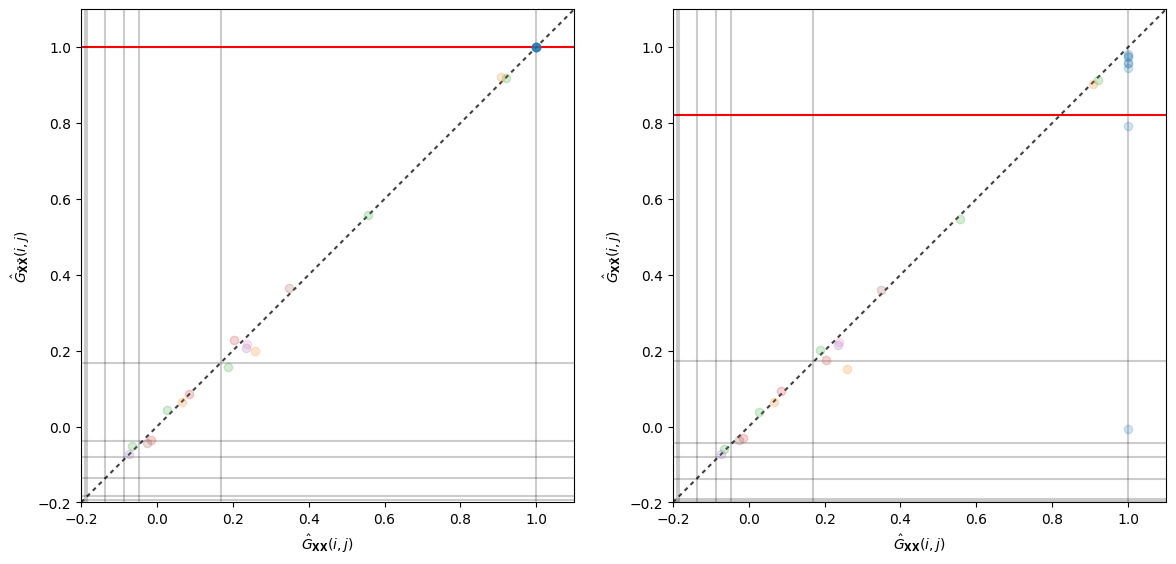

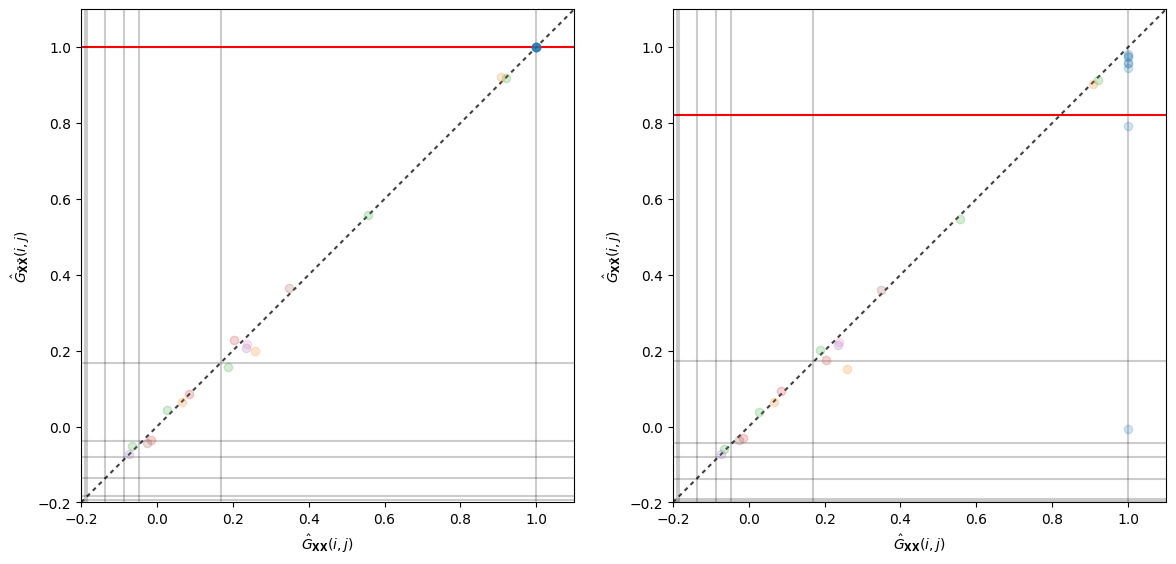

In [ ]:
# Plot diagnostics for deep knockoffs
ScatterCovariance(df, Xk_train_m)

In [ ]:
normalized_df.columns

In [ ]:
knockoffs_g = pd.DataFrame({'cropFrac': Xk_train_g[:, 0], 'grassFrac': Xk_train_g[:, 1],
                            'pastureFrac': Xk_train_g[:, 2], 'treeFrac': Xk_train_g[:, 3],
                            'pr': Xk_train_g[:, 4], 'rsds': Xk_train_g[:, 5],
                            'rsus': Xk_train_g[:, 6], 'tas': Xk_train_g[:, 7]})

In [ ]:
knockoffs_m = pd.DataFrame({'cropFrac': Xk_train_m[:, 0], 'grassFrac': Xk_train_m[:, 1],
                            'pastureFrac': Xk_train_m[:, 2], 'treeFrac': Xk_train_m[:, 3],
                            'pr': Xk_train_m[:, 4], 'rsds': Xk_train_m[:, 5],
                            'rsus': Xk_train_m[:, 6], 'tas': Xk_train_m[:, 7]})

In [ ]:
from google.colab import files

#dataset_g = dataset.to_dataframe()
knockoffs_g.to_csv('knockoffs_g.csv', encoding = 'utf-8-sig')
files.download('knockoffs_g.csv')

knockoffs_m.to_csv('knockoffs_m.csv', encoding = 'utf-8-sig')
files.download('knockoffs_m.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(knockoffs_m.shape)
df_Indonesia.describe()

(1980, 8)


,cropFrac,grassFrac,pastureFrac,treeFrac,pr,rsds,rsus,tas
count,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000
mean,2.233962,7.887044,0.574769,10.440685,0.000089,214.424840,14.593632,299.494091
std,1.179998,0.237141,0.279682,1.342355,0.000026,16.118575,0.964427,0.457626
min,0.655965,6.665079,0.115874,7.795761,0.000024,178.202330,12.292482,297.711500
25%,1.159537,7.769129,0.306323,9.262203,0.000071,202.714095,13.924784,299.179710
50%,2.064210,7.893704,0.586070,10.671391,0.000088,212.588950,14.468960,299.495150
75%,2.895179,8.070385,0.864764,11.663352,0.000108,224.342253,15.111135,299.809943
max,5.291160,8.271665,0.999317,12.399944,0.000167,265.643860,18.287447,301.244140


In [ ]:
print(df_Indonesia.shape)
knockoffs_m.describe()

(1980, 8)


,cropFrac,grassFrac,pastureFrac,treeFrac,pr,rsds,rsus,tas
count,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000
mean,-0.002241,0.037984,0.010810,-0.013871,0.005087,0.012070,0.007499,-0.017534
std,0.987012,0.989807,1.000339,0.993247,1.008567,0.989960,0.998433,1.022794
min,-1.647344,-3.902629,-1.859490,-2.710148,-2.868624,-2.558415,-2.468900,-4.187070
25%,-0.869538,-0.546866,-0.950796,-0.860718,-0.741186,-0.703522,-0.684293,-0.686068
50%,-0.156438,0.160291,0.047042,0.139740,-0.033921,-0.088757,-0.132786,0.008704
75%,0.671229,0.750679,0.988023,0.871082,0.703661,0.600245,0.539027,0.674346
max,2.995348,2.429594,1.757012,1.739240,3.069299,3.096537,3.606123,3.529320


In [ ]:
†print(normalized_df.shape)
normalized_df.describe()

(1980, 8)


,cropFrac,grassFrac,pastureFrac,treeFrac,pr,rsds,rsus,tas
count,1.980000e+03,1.980000e+03,1.980000e+03,1.980000e+03,1.980000e+03,1.980000e+03,1.980000e+03,1.980000e+03
mean,5.741759e-17,-3.961814e-15,5.741759e-17,-2.296704e-16,-3.732144e-16,-1.061777e-15,2.727336e-16,-6.887240e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.337288e+00,-5.152916e+00,-1.640774e+00,-1.970361e+00,-2.534110e+00,-2.247253e+00,-2.386027e+00,-3.895305e+00
25%,-9.105312e-01,-4.972379e-01,-9.598257e-01,-8.779217e-01,-7.196843e-01,-7.265372e-01,-6.935180e-01,-6.869839e-01
50%,-1.438585e-01,2.808269e-02,4.040869e-02,1.718663e-01,-5.421360e-02,-1.138990e-01,-1.292710e-01,2.313081e-03
75%,5.603537e-01,7.731302e-01,1.036876e+00,9.108370e-01,7.224364e-01,6.152785e-01,5.365909e-01,6.901951e-01
max,2.590849e+00,1.621910e+00,1.517968e+00,1.459568e+00,2.973105e+00,3.177639e+00,3.830060e+00,3.824192e+00
